# Finding Patterns in Data
## LSI and Scikit-Learn

$$\begin{align}
	\begin{split}
        \sum \nu \Sigma \Re \epsilon \tau \tau \\
        \beta E \mathbb{R} G \epsilon \S \theta \aleph
	\end{split}
\end{align}$$

In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

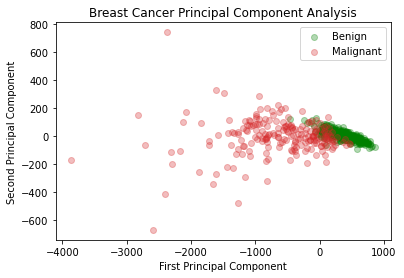

In [30]:
################################################################################
def my_pca(Y, num_components=2):
    Y -= np.mean(Y, axis=0)
    
    # 2. Compute truncated SVD
    U, s, VT = la.svd(Y, full_matrices=False)
    
    # 3. Compute Y hat
    return Y @ VT.T[:,:num_components]

def prob1():
    """Recreate the plot in Figure 1 by performing 
    PCA on the breast cancer dataset.
    Include in the graph title the amount of variance
    captured by the first two principal components."""
    cancer = datasets.load_breast_cancer()
    X = cancer.data
    y = cancer.target # Class labels (0 or 1)
    
    
    # Write a function that performs PCA on the breast cancer dataset. Graph the 
    # first two principal components, with the first along the x-axis.
    Y_hat = my_pca(X)
    
#     pca = PCA(n_components=2) # Create the PCA transformer with hyperparameters
#     Xhat = pca.fit_transform(X)

    mali_x = []
    mali_y = []
    beni_x = []
    beni_y = []
    for i in range(len(y)):
        if y[i] == 1:
            beni_x.append(Y_hat[i,0])
            beni_y.append(Y_hat[i,1])
        else:
            mali_x.append(Y_hat[i,0])
            mali_y.append(Y_hat[i,1])
    plt.scatter(beni_x, beni_y, color='green',
                alpha=.3, label='Benign')
    plt.scatter(mali_x, mali_y, color='tab:red',
                alpha=.3, label='Malignant')
    plt.legend()
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.title("Breast Cancer Principal Component Analysis")
    plt.show()
    

prob1()

## Problem 2
Implement the function similar()

In [3]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components and returns the indices of
    the documents that are the most and least similar to i.
    
    Parameters:
    i index of a document
    Xhat decomposed data: n x l
    
    Returns:
    index_min: index of the document most similar to document i
    index_max: index of the document least similar to document i
    """
    results = [np.inner(Xhat[i], Xhat[j]) / (la.norm(Xhat[i]) * la.norm(Xhat[j]))
               for j in range(len(Xhat))]
    argsorted = np.argsort(results)
    return argsorted[-2], argsorted[0]


### Function for Problem 3

In [4]:
def document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [5]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 principal
    components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    X, paths = document_converter()
    index = paths.index(speech)

    # Do LSI
    U, s, VT = sparse.linalg.svds(X, k=l)
    X_hat = X @ VT.T[:,:l]
    
    # Calculate most and least similar
    most, least = similar(index, X_hat)
    
    # Clean path text
    def clean_path(path):
        return path.split("/")[-1].split(".")[0]
    
    return clean_path(paths[most]), clean_path(paths[least])

In [6]:
#Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [7]:
def weighted_document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
    A (sparse matrix, n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab))
    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count
                    
    # get global weights

    #Problem 4
    # student work begins here
    
    # m = # of documents
    # n = # of terms
    m = len(set(doc_index))
    n = len(set(word_index))

    # Calculate p_ij, gj
    g = np.ones(n)
    for i in range(len(counts)):
        doc = doc_index[i]
        word = word_index[i]
        p_ij = counts[i] / t[word]
        g[word] += p_ij * np.log(p_ij + 1) / np.log(m)
    
    a = []
    for i in range(len(counts)):
        word = word_index[i]
        count = counts[i]
        a.append(g[word] * np.log(count + 1))
    
    A = sparse.csr_matrix((a, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return A, paths


## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [8]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with the
    first 7 principal components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    X, paths = weighted_document_converter()
    index = paths.index(speech)

    # Do LSI
    pca = PCA(n_components=7) # Create the PCA transformer with hyperparameters
    x_compressed = X.todense()
    Xhat = pca.fit_transform(x_compressed)
    
    # Calculate most and least similar
    most, least = similar(index, Xhat)
    
    # Clean path text
    
    return paths[most], paths[least]

In [26]:
#Run this box after you have completed prob5()
speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

('./Addresses/1985-Reagan.txt', './Addresses/1961-Kennedy.txt')
('./Addresses/1994-Clinton.txt', './Addresses/1951-Truman.txt')


## Problem 6
- Split the breast cancer dataset into training and testing sets using random_state=2
- Fit KNeighborsClassifier and RandomForestClassifier to the training data
- Predict labels for the testing set
- Print a classification_report for each classifier
- Write a few sentences explaining which classifier would be better to use in this situation and why

In [10]:
# Split the breast cancer dataset into training and testing sets
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=2)

# Random Forest Classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)

# K Neighbors Classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

print("Random Forest scores")
print(classification_report(y_test, forest_predicted))
print("\n-------------------------------------------\n")
print("K Nearest Neighbors scores")
print(classification_report(y_test, knn_predicted))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # 
#                                                     # 
#  In this case, we want to get the least amount of   #
#  false negatives as possible because those people   #
#  would die from the cancer. So we want to maximize  #
#  recall instead of precision.                       #
#  We can see that recall is higher on the Random     #
#  Forest Classifier, so we would rather have that    #
#  for a situation where people's lives are at stake  #
#  rather than letting them go home with malignant    #
#  cancer in them.                                    #
#                                                     # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # #

Random Forest scores
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.95      0.95      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143


-------------------------------------------

K Nearest Neighbors scores
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        56
           1       0.93      0.94      0.94        87

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



## Problem 7
- Use the breast cancer dataset split from Problem 6
- Run a GridSearch with a RandomForestClassifier, modifying at least three parameters.
- Use scoring="f1"
- Print out best_params_ and best_score_
- Print a confusion matrix for the test data

In [11]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=2)

# Random Forest Classifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)
param_grid = {"max_depth": [4, 25, 100],
              "min_samples_leaf": [5, 10, 20],
              "n_estimators" : [100, 500]
              }
forest_gs = GridSearchCV(forest, param_grid, scoring="f1", n_jobs=-1)

# Run the actual search. This may take some time.
forest_gs.fit(X_train, y_train)

# After fitting, you can access data about the results.
print(forest_gs.best_params_, forest_gs.best_score_, sep='\n')

# Next, use the GridSearchCV object to predict labels for your test set. 
# Print out a confusion matrix using these values
gs_pred = forest_gs.predict(X_test)
CM = confusion_matrix(y_test, gs_pred)
print(CM)

{'max_depth': 25, 'min_samples_leaf': 5, 'n_estimators': 100}
0.9724408970091899
[[52  4]
 [ 5 82]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least .96

In [25]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=2)

pipe = Pipeline([("scaler", StandardScaler()),
                 ("PCA", PCA()),
                 ("classifier", KNeighborsClassifier())])
# Create the grid
pipe_param_grid = [
    {"classifier": [KNeighborsClassifier()], # Try a KNN classifier...
    "classifier__n_neighbors": [2,3,4,5],
    "classifier__weights": ["uniform", "distance"],
    "classifier__algorithm": ["ball_tree", "kd_tree", "brute"]},
    {"PCA": [PCA()],
    "PCA__n_components": [2, 5],
    "PCA__whiten": [True, False]},
    {"scaler": [StandardScaler()],
     "scaler__copy": [True, False]}]

# Fit using training data
pipe_gs = GridSearchCV(pipe, pipe_param_grid,
                       scoring="f1", n_jobs=-1).fit(X_train, y_train)
# Get the best hyperparameters and score
print("Best Parameters:", pipe_gs.best_params_, sep='\n')
print("\nBest Score: {}".format(pipe_gs.best_score_))

Best Parameters:
{'classifier': KNeighborsClassifier(algorithm='ball_tree', n_neighbors=4, weights='distance'), 'classifier__algorithm': 'ball_tree', 'classifier__n_neighbors': 4, 'classifier__weights': 'distance'}

Best Score: 0.9782136765623004
